In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from matplotlib import style
import seaborn as sns
from IPython.core.pylabtools import figsize
import warnings
import statsmodels.api as sm

%matplotlib inline
plt.style.use('ggplot')

In [3]:
np.random.seed(2019)

In [4]:
# Read all historical sales data and index data
df = pd.read_csv('downloads/BTC-PERPETUAL.txt')

In [5]:
# Properly index the pandas dataframe
df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
df.index = df['date']
df = df.drop(columns=['timestamp', 'date'])
df.columns = ['date', 'perpetual', 'index']

In [6]:
df['ratio'] = df['perpetual'] / df['index']

In [7]:
df.describe()

,perpetual,index,ratio
count,2.739576e+07,2.739576e+07,2.739576e+07
mean,8.793806e+03,8.790548e+03,1.000265e+00
std,2.473821e+03,2.470238e+03,2.642148e-03
min,3.121500e+03,3.126330e+03,8.501664e-01
25%,7.703750e+03,7.701290e+03,9.996183e-01
50%,9.444000e+03,9.442560e+03,1.000240e+00
75%,1.056100e+04,1.055535e+04,1.000883e+00
max,1.391450e+04,1.385573e+04,1.251092e+00


In [6]:
df_D = df.resample('D').last().interpolate()

In [80]:
df.resample('8H').last().interpolate().describe()

,perpetual,index,ratio
count,1338.000000,1338.000000,1338.000000
mean,6772.631726,6771.830643,0.999992
std,2595.348401,2592.762525,0.000808
min,3140.000000,3141.320000,0.995980
25%,3991.250000,3992.470000,0.999481
50%,6431.250000,6433.255000,0.999993
75%,8747.250000,8739.232500,1.000493
max,12937.500000,12926.800000,1.003497


In [7]:
df_D.to_csv('daily_perpetual_spot_ratio.csv')

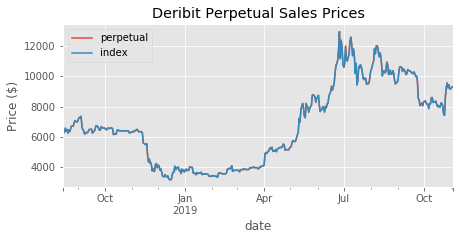

In [29]:
figsize(7,3)
df_D.plot(y=['perpetual', 'index'])
plt.ylabel('Price ($)')
plt.title('Deribit Perpetual Sales Prices')
plt.show()

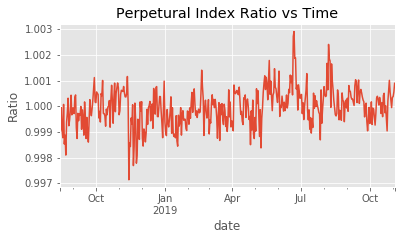

In [30]:
figsize(6,3)
df_D.plot(y='ratio', legend=False)
plt.ylabel('Ratio')
plt.title('Perpetural Index Ratio vs Time')
plt.show()

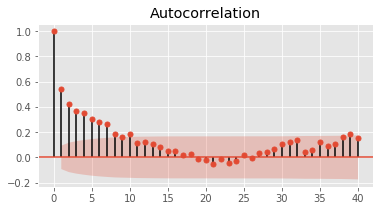

In [53]:
sm.graphics.tsa.plot_acf(df_D['ratio'], lags=40)
plt.show()

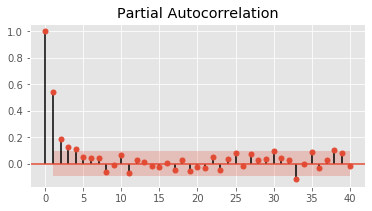

In [56]:
sm.graphics.tsa.plot_pacf(df_D['ratio'], lags=40)
plt.show()

In [66]:
sm.tsa.stattools.adfuller(df_D['ratio'], maxlag=10, regression='ct')

(-6.314735984634745,
 4.678722300365411e-07,
 3,
 443,
 {'1%': -3.9793522915426682,
  '5%': -3.4204471749378556,
  '10%': -3.1329068263745925},
 -5234.242543485603)

In [67]:
df_D_diff = df_D['ratio'].diff()[1:]

In [73]:
sm.tsa.stattools.adfuller(df_D_diff, maxlag=10, regression='ct')

(-10.033224693489473,
 1.962353349225152e-15,
 8,
 437,
 {'1%': -3.9796369453725298,
  '5%': -3.4205845422066594,
  '10%': -3.1329875260529962},
 -5197.00904872605)

First difference is clearly stationary. Some evidence that no diff is not stationary. DF test c, ct, and ctt all reject null, but not DF test with nc.

Estimate Models with Both

In [75]:
res = sm.tsa.arma_order_select_ic(df_D['ratio'], max_ar=5, max_ma=5, ic=['aic', 'bic'], fit_kw={'method':'css-mle'})
print(res)

C:\Users\chris\.conda\envs\data\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:649: RuntimeWarning: divide by zero encountered in true_divide
  R_mat, T_mat)
C:\Users\chris\.conda\envs\data\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\chris\.conda\envs\data\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\chris\.conda\envs\data\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\chris\.conda\envs\data\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\chris\.conda\envs\data\lib\site-packages\statsmodels\base\model.p

{'aic':              0            1            2            3            4  \
0 -5180.704496 -5280.219359 -5311.576438 -5322.052563 -5330.564203   
1 -5333.072907 -5357.503554 -5358.480995 -5356.524349          NaN   
2 -5346.739381 -5358.438353 -5356.503612 -5354.708097 -5270.102621   
3 -5351.237785 -5356.547647 -5354.439180          NaN -5327.036950   
4 -5355.017719 -5355.169046 -5353.183672 -5358.069382          NaN   
5 -5354.311319 -5351.017978 -5351.998921 -5356.288051          NaN   

             5  
0 -5335.781545  
1 -5353.277258  
2          NaN  
3 -5323.770297  
4 -5355.820691  
5 -4386.224784  , 'bic':              0            1            2            3            4  \
0 -5172.499379 -5267.911683 -5295.166203 -5301.539770 -5305.948851   
1 -5320.765231 -5341.093320 -5337.968202 -5331.908998          NaN   
2 -5330.329146 -5337.925560 -5331.888260 -5325.990186 -5237.282153   
3 -5330.724992 -5331.932295 -5325.721270          NaN -5290.113923   
4 -5330.402367 -5326.451

C:\Users\chris\.conda\envs\data\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\chris\.conda\envs\data\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
best_aic_model = None
best_bic_model = None
lowest_AIC = float('inf')
lowest_BIC = float('inf')
for p in range(15):
    for q in range(15):
        for d in range(2):
            try:
                model = sm.tsa.ARIMA(df_D['ratio'], (p,d,q)).fit()
                if model.aic < lowest_AIC:
                    best_aic_model = model
                    lowest_AIC = model.aic
                if model.bic < lowest_BIC:
                    best_bic_model = model
                    lowest_BIC = model.bic
            except:
                pass

In [ ]:
sm.tsa.ARIMA(df_D['ratio'], (20,0,1)).fit().summary()

In [ ]:
model = sm.tsa.ARIMA(df_D['ratio'], (5,1,2)).fit(disp=False)
model.summary()

In [12]:
df.loc['2018-12-01':'2018-12-07']['ratio'].resample('1Min').last().interpolate().describe()

count    10080.000000
mean         0.998998
std          0.000896
min          0.993191
25%          0.998457
50%          0.998994
75%          0.999573
max          1.002621
Name: ratio, dtype: float64